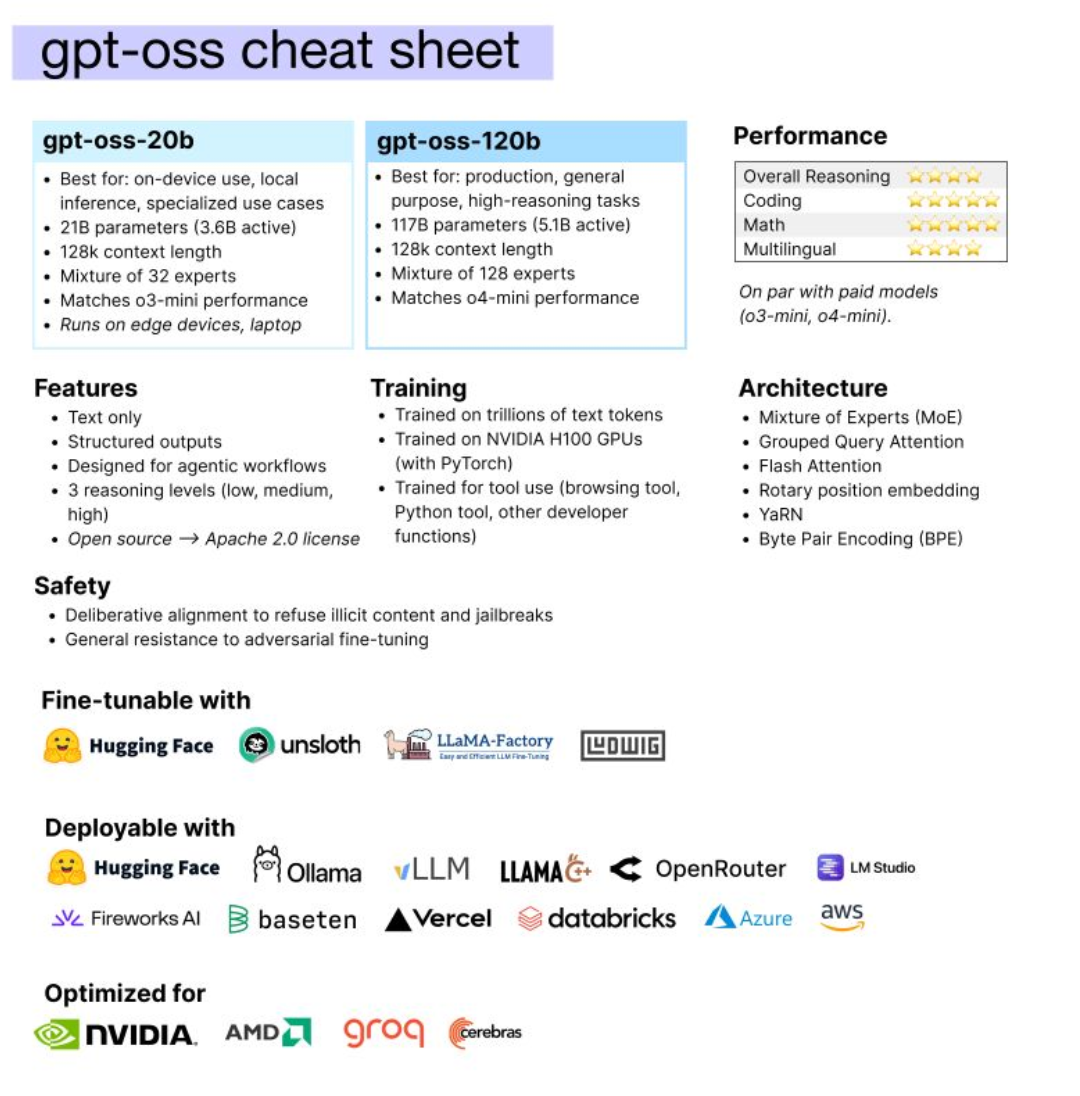

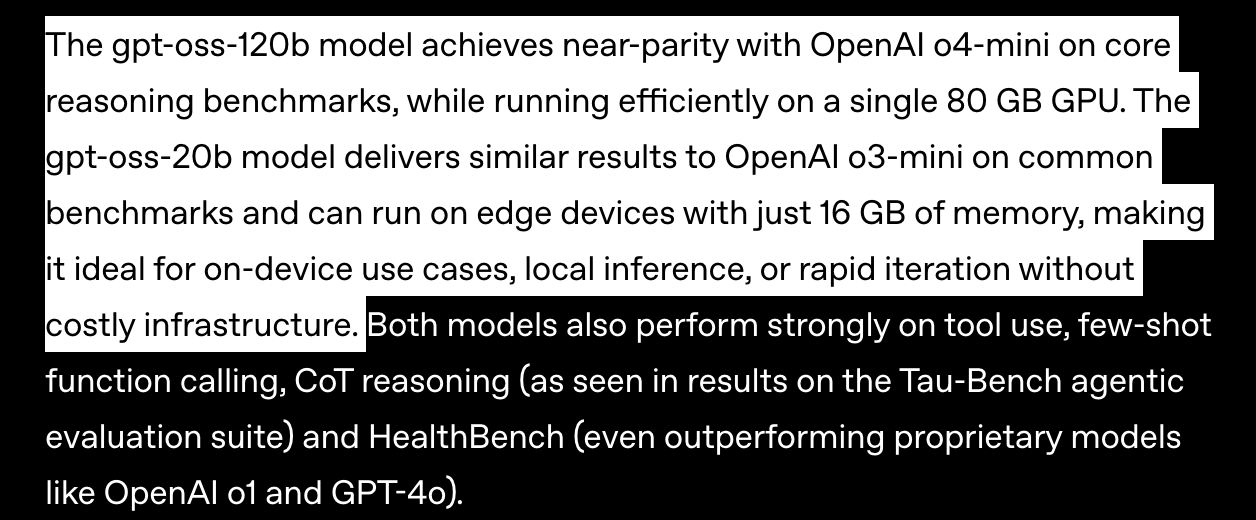

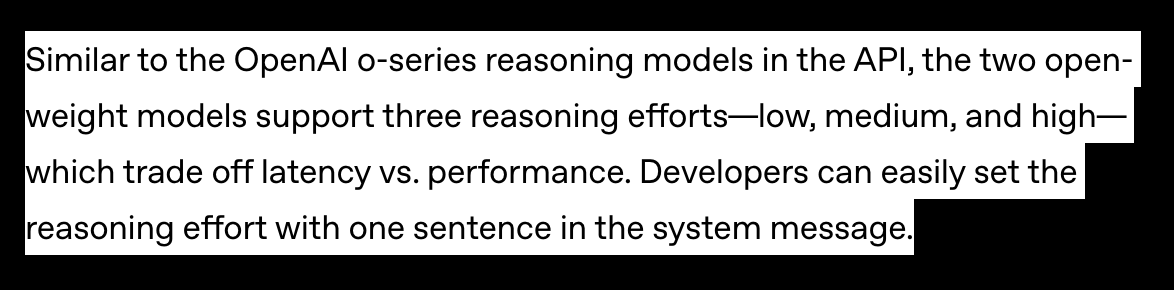

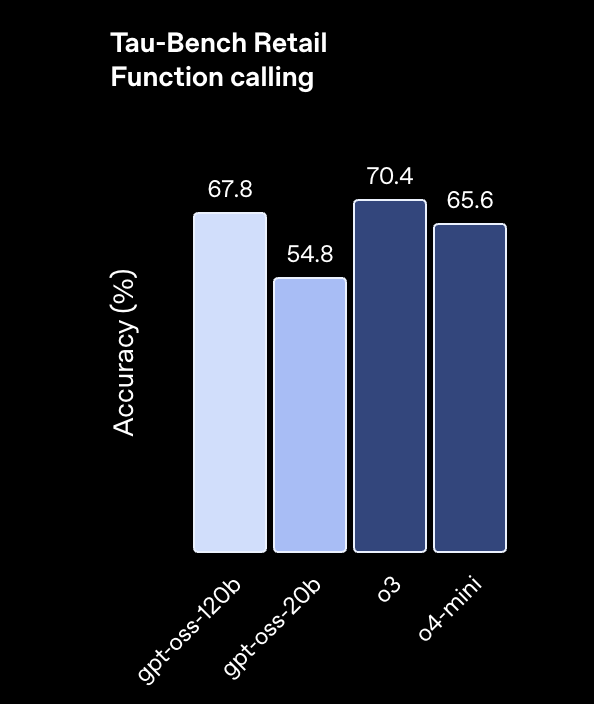

#### For production and high reasoning tasks 
ollama pull gpt-oss:120b
#### For lower latency and local deployment 
ollama pull gpt-oss:20b

### Installations

In [1]:
! uv pip install langchain langchain-community -q
! uv pip install sentence-transformers langchain_huggingface -q
! uv pip install datasets -q
! uv pip install chromadb -q
! uv pip install langchain_ollama -q

### RAG Building

In [2]:
import datasets
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.docstore.document import Document
#from langchain_community.retrievers import BM25Retriever

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")
knowledge_base = knowledge_base.filter(lambda row: row["source"].startswith("huggingface/transformers"))

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
new_docs = text_splitter.split_documents(documents=source_docs)

/Users/aritrasen/Documents/code/agents_observability/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
###  BGE Embddings

from langchain_huggingface import HuggingFaceEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "mps"} ### use "cuda" for GPU or "cpu" for CPU or "mps" for Apple Silicon
encode_kwargs = {"normalize_embeddings": True}
embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)

### Populate Vector DB

db = Chroma.from_documents(new_docs,embeddings,persist_directory='data')

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [4]:
retriever = db.as_retriever(search_kwargs={"k": 4})

In [5]:
retriever.invoke('Tell me about Key matrices in Transformer')

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(metadata={'source': 'transformers', 'start_index': 31045}, page_content='|                  [Transformer-XL](model_doc/transfo-xl)                  |       ✅        |         ✅         |      ❌      |\n|                         [TrOCR](model_doc/trocr)                         |       ✅        |         ❌         |      ❌      |\n|                          [TVLT](model_doc/tvlt)                          |       ✅        |         ❌         |      ❌      |'),
 Document(metadata={'start_index': 3309, 'source': 'transformers'}, page_content='### Axial Positional Encodings'),
 Document(metadata={'source': 'transformers', 'start_index': 29893}, page_content='|           [SwitchTransformers](model_doc/switch_transformers)            |       ✅        |         ❌         |      ❌      |\n|                            [T5](model_doc/t5)                            |       ✅        |         ✅         |      ✅      |\n|                        [T5v1.1](model_doc/t5v1.1)                    

### gpt-oss 20B model initialization

In [ ]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

llm=ChatOllama(
    model='gpt-oss:20b',
    base_url="http://localhost:11434",
    temperature=0.0
)

### Questions to Reasoning model

In [75]:
def get_system_prompts(effort):
    """ Generate system prompts based on the reasoning effort level.

    Args:
        effort (str): The level of reasoning effort ('low', 'medium', 'high').

    Returns:
        list: A list of messages formatted as system prompt for the LLM.
    """
    system_prompts = {
        'low': 'You are a helpful assistant. Provide concise, direct answers.',
        'medium': f'You are a helpful assistant. Show brief reasoning before your answer. Reasoning effort: {effort}',
        'high': f'You are a helpful assistant. Show complete chain-of-thought reasoning step by step. Think through the problem carefully before providing your final answer. Reasoning effort: {effort}'
    }
    msgs = [{'role': 'system', 'content': system_prompts[effort]}]
    return msgs , system_prompts[effort]

In [ ]:
  
msgs , content = get_system_prompts('low')

question = "What is the role of Key matrices in Transformer architecture?"

msgs.append([{'role': 'user', 'content': question}])  

print("Messages to LLM:", msgs)

Messages to LLM: [{'role': 'system', 'content': 'You are a helpful assistant. Provide concise, direct answers.'}, [{'role': 'user', 'content': 'What is the role of Key matrices in Transformer architecture?'}]]


In [10]:
response = llm.invoke(msgs)

In [12]:
print(response.content)

In a Transformer’s self‑attention layer each token’s embedding is linearly projected into three vectors: **query (Q)**, **key (K)**, and **value (V)**.  
The **key matrix** (the collection of all K vectors) is used to compute the attention scores:

1. **Projection** – Each input token is multiplied by a learned weight matrix \(W_k\) to produce its key vector.  
2. **Matching** – For every query vector \(q_i\) (from token *i*), the dot product \(q_i \cdot K_j\) is taken with every key vector \(k_j\) (from token *j*).  
3. **Weighting** – These dot products (scaled and softmaxed) give the attention weights that decide how much token *j* contributes to token *i*’s output.

Thus, keys encode the “content” of each token that is compared against queries to determine relevance, enabling the model to focus on the most informative parts of the sequence.


In [82]:
msgs , content = get_system_prompts('medium')

question = "What is the role of Key matrices in Transformer architecture?"

msgs.extend([{'role': 'user', 'content': question}])  

print("Messages to LLM:", msgs)

response = llm.invoke(msgs)

print(response.content)

Messages to LLM: [{'role': 'system', 'content': 'You are a helpful assistant. Show brief reasoning before your answer. Reasoning effort: medium'}, {'role': 'user', 'content': 'What is the role of Key matrices in Transformer architecture?'}]
**Key matrices (the “K” in Q‑K‑V) are the part of the Transformer that lets the model decide *which* other tokens are relevant to a given token.**  

---

### 1. Where they come from  
- Every token’s embedding \(x_i\) is linearly projected into three vectors:  
  \[
  q_i = W_Q x_i,\qquad k_i = W_K x_i,\qquad v_i = W_V x_i
  \]  
  The matrices \(W_Q, W_K, W_V\) are learned weight matrices.  
- Stacking all \(k_i\) gives the **key matrix** \(K \in \mathbb{R}^{n \times d_k}\) (for \(n\) tokens, key dimension \(d_k\)).  
- In multi‑head attention, each head has its own \(W_K\), so we get a separate key matrix per head.

### 2. How they are used in attention  
The core of self‑attention (and cross‑attention) is:

\[
\text{Attention}(Q,K,V) = \text{sof

In [83]:
msgs , content = get_system_prompts('high')

question = "What is the role of Key matrices in Transformer architecture?"

msgs.extend([{'role': 'user', 'content': question}])  

print("Messages to LLM:", msgs)

response = llm.invoke(msgs)

print(response.content)

Messages to LLM: [{'role': 'system', 'content': 'You are a helpful assistant. Show complete chain-of-thought reasoning step by step. Think through the problem carefully before providing your final answer. Reasoning effort: high'}, {'role': 'user', 'content': 'What is the role of Key matrices in Transformer architecture?'}]
### Quick answer  
In a Transformer, the **Key matrix (K)** is one of the three linear projections (Query Q, Key K, Value V) that turn the input token embeddings into a form that can be used for *dot‑product attention*.  
- **K** stores a “key” representation for every token.  
- It is multiplied by the Query matrix to produce the attention scores (Q Kᵀ).  
- Those scores decide how much each token should “pay attention” to every other token.  
- The scores are then used to weight the Value matrix, producing the final context‑aware token representations.

---

## 1. Where the Key matrix comes from

| Step | What happens | Why it matters |
|------|--------------|-----

### Retrieval Chain Creation

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables import RunnablePassthrough

In [58]:
msgs , content = get_system_prompts('low')
content

'You are a helpful assistant. Provide concise, direct answers.'

In [62]:
prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(content),
            HumanMessagePromptTemplate.from_template(""" Answer the question based only on the following context:
                                                        {context}
                                                        Question: {question}
                                                     """)
        ]
    )

In [63]:
retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

### Testing Reasoning RAG

In [65]:
result = retrieval_chain.invoke('Tell me about Key matrices in Transformer')

In [66]:
print(result)

Key matrices (the **K** in Q‑K‑V) are one of the three core tensors used in a Transformer’s self‑attention mechanism.  
- They are matrices of shape **seq_len × hidden_size** (ignoring the batch and head dimensions).  
- Together with the query (Q) and value (V) matrices, they are multiplied (Q × Kᵀ) to produce the raw attention scores that are then scaled, masked, and soft‑maxed to give the attention weights.  
- These weights are applied to the value matrix to produce the final context‑aware representations.  

In short, the key matrix holds the “keys” that the queries are compared against to decide how much each token should attend to every other token.


### Reasoning Mode - medium

In [70]:
msgs , content = get_system_prompts('medium')

print('system prompt:',content)

prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(content),
            HumanMessagePromptTemplate.from_template(""" Answer the question based only on the following context:
                                                        {context}
                                                        Question: {question}
                                                     """)
        ]
    )

retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

system prompt: You are a helpful assistant. Show brief reasoning before your answer. Reasoning effort: medium


In [71]:
result = retrieval_chain.invoke('Tell me about Key matrices in Transformer')

In [73]:
print(result)

**Key matrices (K) in a Transformer**

- In the self‑attention mechanism of a Transformer, each token in the input sequence is projected into three vectors: **Query (Q)**, **Key (K)**, and **Value (V)**.  
- The **Key matrix** is a collection of the key vectors for all tokens.  
- It has the shape **`seq_len × hidden_size`** (ignoring the batch and head dimensions that are present in the full implementation).  
- During attention, the Key matrix is multiplied (via a dot product) with the Query matrix to produce the raw attention scores. These scores are then scaled, masked, and soft‑maxed to obtain the attention weights, which are finally applied to the Value matrix.  
- Thus, the Key matrix plays the role of a “lookup table” that the Query vectors use to determine how much each token should attend to every other token.
